In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/root ai internship work/root2ai - Data.csv")

In [ ]:
df.head()

,Text,Target
0,reserve bank forming expert committee based in...,Blockchain
1,director could play role financial system,Blockchain
2,preliminary discuss secure transaction study r...,Blockchain
3,security indeed prove essential transforming f...,Blockchain
4,bank settlement normally take three days based...,Blockchain


In [ ]:
df.dropna(inplace=True)

In [ ]:
from io import StringIO
col = ['Target', 'Text']
df = df[col]
df = df[pd.notnull(df['Text'])]
df.columns = ['Target', 'Text']
df['category_id'] = df['Target'].factorize()[0]
category_id_df = df[['Target', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Target']].values)
df.head()

,Target,Text,category_id
0,Blockchain,reserve bank forming expert committee based in...,0
1,Blockchain,director could play role financial system,0
2,Blockchain,preliminary discuss secure transaction study r...,0
3,Blockchain,security indeed prove essential transforming f...,0
4,Blockchain,bank settlement normally take three days based...,0


In [ ]:
df.isnull().sum()

Target         0
Text           0
category_id    0
dtype: int64

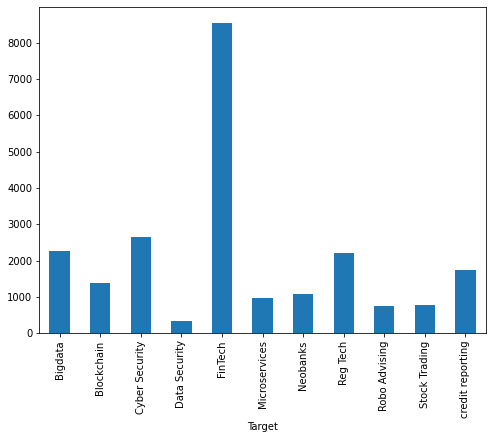

In [ ]:
#Imbalanced Classes
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Target').Text.count().plot.bar(ylim=0)
plt.show()

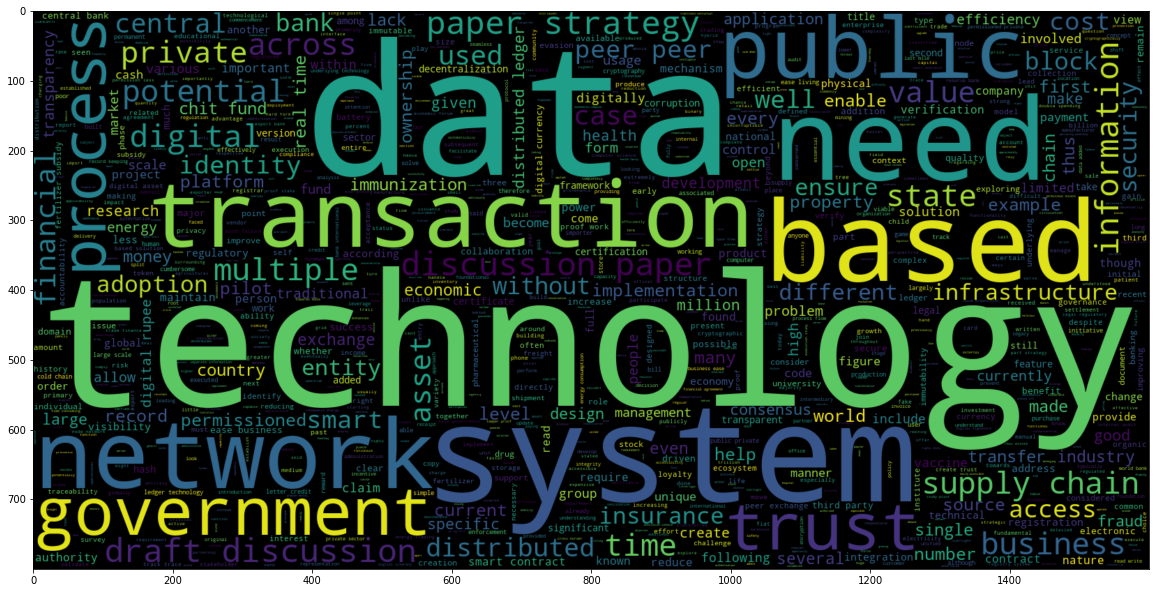

In [28]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.Target == 'Blockchain'].Text))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Text).toarray()
labels = df.category_id
features.shape

(22701, 6401)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Target, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Target))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bigdata':
  . Most correlated unigrams:
. ncbi
. retrieved
  . Most correlated bigrams:
. pmid pubmed
. retrieved october
# 'Blockchain':
  . Most correlated unigrams:
. chit
. permissioned
  . Most correlated bigrams:
. draft discussion
. paper strategy
# 'Cyber Security':
  . Most correlated unigrams:
. para
. security
  . Most correlated bigrams:
. information security
. security digital
# 'Data Security':
  . Most correlated unigrams:
. privacy
. protection
  . Most correlated bigrams:
. personal data
. data protection
# 'FinTech':
  . Most correlated unigrams:
. start
. data
  . Most correlated bigrams:
. financial advisory
. advisory group
# 'Microservices':
  . Most correlated unigrams:
. application
. architecture
  . Most correlated bigrams:
. cloud native
. architectural style
# 'Neobanks':
  . Most correlated unigrams:
. valuation
. starling
  . Most correlated bigrams:
. sanction scanner
. starling bank
# 'Reg Tech':
  . Most correlated unigrams:
. regulators
. regtech
 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Target'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
#After fitting the training set, let’s make some predictions.

print(clf.predict(count_vect.transform(["stock exchange stock exchange world whereas stock exchange"])))

['Stock Trading']


In [ ]:
df[df['Text'] == "stock exchange stock exchange world whereas stock exchange"]

,Target,Text,category_id
19857,Stock Trading,stock exchange stock exchange world whereas st...,8


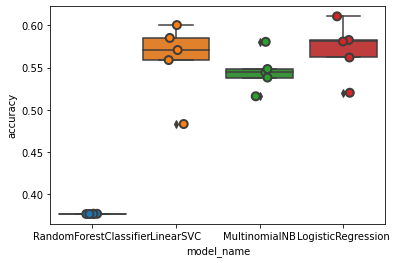

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.559582
LogisticRegression        0.571211
MultinomialNB             0.545440
RandomForestClassifier    0.376768
Name: accuracy, dtype: float64

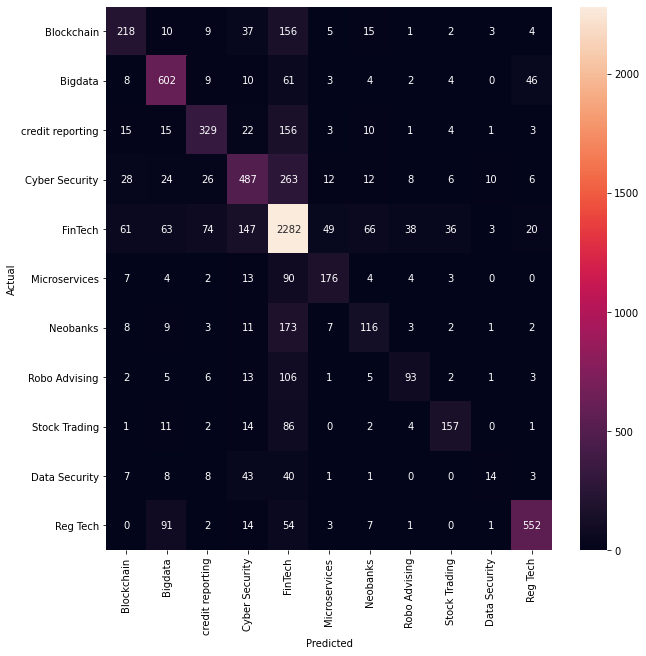

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Target.values, yticklabels=category_id_df.Target.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Target', 'Text']])
      print('')


'credit reporting' predicted as 'Blockchain' : 15 examples.


,Target,Text
4874,credit reporting,technology also information thus manage collec...
4055,credit reporting,this peer peer property balance sheet property...
3880,credit reporting,provided central bank
4782,credit reporting,involve person person person business business...
4793,credit reporting,employ cryptographic algorithmic record synchr...
5070,credit reporting,this technology also help data control access ...
3662,credit reporting,these million sometimes file
4773,credit reporting,many already technology legislation enable ben...
4148,credit reporting,billion japan primarily business property
4165,credit reporting,billion made vibrant business consumer propert...



'Cyber Security' predicted as 'Blockchain' : 28 examples.


,Target,Text
6887,Cyber Security,privately facilitate peer peer exchange possib...
7056,Cyber Security,transparent immutable data fraudulent
5981,Cyber Security,include organic development trust amongst ecos...
6997,Cyber Security,business standard
6232,Cyber Security,however identity verification excessive verifi...
7049,Cyber Security,private distributed ledger white paper adoptio...
6869,Cyber Security,technology
5966,Cyber Security,initiative year
5554,Cyber Security,march minister state electronics informed parl...
6183,Cyber Security,effectively respond implement privacy respecti...



'FinTech' predicted as 'Blockchain' : 61 examples.


,Target,Text
13578,FinTech,wall street journal article written march
12635,FinTech,disruptiveness quite wide ranging
9829,FinTech,product regulatory oversight sometimes lead ra...
12364,FinTech,taxation come play goods alter dramatically ne...
12914,FinTech,entity identification first political need
...,...,...
9244,FinTech,this stark contrast trust advantage lend
8115,FinTech,latest version electronic document
8103,FinTech,hand virtual sign permitted sometimes hard est...
9843,FinTech,must also aware digital literacy



'Blockchain' predicted as 'Bigdata' : 10 examples.


,Target,Text
1369,Blockchain,prevent dishonest behavior public offer econom...
639,Blockchain,pencil cedar graphite lacquer ferrule
1310,Blockchain,mathematical convert data indeterminate length...
443,Blockchain,prolong
203,Blockchain,among
32,Blockchain,task exposition technical serious
725,Blockchain,well
593,Blockchain,prevention opportunistic behavior
424,Blockchain,data quality massive replication computational...
1352,Blockchain,collectible movable movable



'credit reporting' predicted as 'Bigdata' : 15 examples.


,Target,Text
4747,credit reporting,analysis data identify hidden behavior could u...
4092,credit reporting,volume
4890,credit reporting,data
5063,credit reporting,thus need ensure process data quality data
3818,credit reporting,community june august
5233,credit reporting,although data becoming available data unleash ...
4191,credit reporting,interest
5357,credit reporting,republic
4749,credit reporting,amount digital data large part data double eve...
5318,credit reporting,most



'Cyber Security' predicted as 'Bigdata' : 24 examples.


,Target,Text
6384,Cyber Security,combat biometric based three namely failure en...
6965,Cyber Security,data business activity information becoming av...
5679,Cyber Security,august
7403,Cyber Security,review
5820,Cyber Security,house royal institute international house roya...
6156,Cyber Security,these must executed soon possible data fiducia...
5677,Cyber Security,justice
5543,Cyber Security,just last month revealed massive amount data
7402,Cyber Security,review
7993,Cyber Security,data indexing analytics help information outli...



'FinTech' predicted as 'Bigdata' : 63 examples.


,Target,Text
14870,FinTech,would form hypothesis maybe talk customer reac...
9253,FinTech,this behavior
12720,FinTech,data false efficiently
12385,FinTech,depth antiquated data
11906,FinTech,hesitant
...,...,...
12439,FinTech,once biggest warehouse today warehouse stock
16344,FinTech,shoplifting
15315,FinTech,soaring
12410,FinTech,ardent quest



'Stock Trading' predicted as 'Bigdata' : 11 examples.


,Target,Text
20022,Stock Trading,crude
20003,Stock Trading,sampling process
19934,Stock Trading,moreover
20037,Stock Trading,made million march triple made march
19803,Stock Trading,freshly field usually examine
19698,Stock Trading,equity data
19597,Stock Trading,short time usually closed
19629,Stock Trading,they perform model nearest neighbor model base...
20079,Stock Trading,mike based attorney part case three march gone
19676,Stock Trading,data large stocks analyze data august



'Reg Tech' predicted as 'Bigdata' : 91 examples.


,Target,Text
21693,Reg Tech,Dahl
21488,Reg Tech,Isaac Melanie
20770,Reg Tech,feab
21651,Reg Tech,HUDN takeover Sybenetix comes amid wave intere...
20551,Reg Tech,RegTech While analysing different touch points...
...,...,...
21659,Reg Tech,bankingtech
21404,Reg Tech,American population still considered unbanked ...
21756,Reg Tech,Uncertain makes harder financial companies cho...
21300,Reg Tech,STUD



'Cyber Security' predicted as 'credit reporting' : 26 examples.


,Target,Text
5727,Cyber Security,annex
7158,Cyber Security,with mobile usage increase percent percent cur...
6925,Cyber Security,these designed increase efficiency reduce time...
7454,Cyber Security,crop insurance provide credit niche micro small
7163,Cyber Security,recent study potential efficiency risk reducti...
7449,Cyber Security,enhanced mobile banking increase formal credit...
5567,Cyber Security,consumer penetration along customer centric
7194,Cyber Security,world bank group world bank actively work rele...
7442,Cyber Security,across nation taking advantage expanding finan...
6671,Cyber Security,cloud specifically enable foreign make binding...



'FinTech' predicted as 'credit reporting' : 74 examples.


,Target,Text
8319,FinTech,they light ongoing development supervisory int...
12584,FinTech,generally acting small give good therefore con...
8384,FinTech,credit data
9335,FinTech,given still ethics self regulation
10556,FinTech,business would bank credit borrow peer peer sp...
...,...,...
8902,FinTech,instance digital provide better service
16114,FinTech,rent platform without fully
10968,FinTech,data problem also bank
14535,FinTech,product needs current personal credit digital



'Blockchain' predicted as 'Cyber Security' : 37 examples.


,Target,Text
830,Blockchain,example physical assets digital representation
791,Blockchain,several recent past evaluate applicability bas...
1091,Blockchain,however current system digital certification d...
1090,Blockchain,address problem several digital
812,Blockchain,case selection framework
499,Blockchain,opening research technology order explore used...
321,Blockchain,limited enforcement could used corral egregious
836,Blockchain,block representation object transaction feasible
1070,Blockchain,scope project track trace beyond traditional v...
169,Blockchain,would also need address consumer protection



'Bigdata' predicted as 'Cyber Security' : 10 examples.


,Target,Text
3415,Bigdata,page
1624,Bigdata,contact
2955,Bigdata,national security agency central security service
2091,Bigdata,such mappings used media industry companies go...
2035,Bigdata,civil registration vital statistics crvs colle...
1820,Bigdata,this security breach fintech product wreak havoc
1574,Bigdata,naturally policy strong influence stability ma...
3033,Bigdata,conversation
2972,Bigdata,wingfield nick march
2826,Bigdata,couldry nick turow joseph



'credit reporting' predicted as 'Cyber Security' : 22 examples.


,Target,Text
4691,credit reporting,through technical assistance advisory team dev...
4493,credit reporting,further increasing participation income credit...
4606,credit reporting,specifically establishment responsible flexibl...
5249,credit reporting,team best offer balanced approach financial in...
5169,credit reporting,thus regulated regulatory framework relevant b...
5187,credit reporting,also framework sandbox
4711,credit reporting,time millions people access formal finance fir...
4984,credit reporting,with increasing amount data veracity data also...
5190,credit reporting,charge hacienda national banking commission bank
4508,credit reporting,deterrent lack trust banking financial system ...



'FinTech' predicted as 'Cyber Security' : 147 examples.


,Target,Text
12297,FinTech,growing ecosystem
11750,FinTech,these purposefully pushing encouraging fosteri...
11583,FinTech,with international melting
8884,FinTech,payment three critical payment namely digital ...
13665,FinTech,tsunami legislation regulation
...,...,...
14699,FinTech,commonly used contain hacker exploit
9401,FinTech,company specific category wide weighed digital
8082,FinTech,first step already public seek input strong cu...
8420,FinTech,enhanced information security management incre...



'Microservices' predicted as 'Cyber Security' : 13 examples.


,Target,Text
16712,Microservices,This make difficult switch also operational co...
17266,Microservices,lockup fair share attractive neither seen over...
16966,Microservices,rolling feature testing
16889,Microservices,high degree risk also bring entire system
17340,Microservices,Finally considered importance system reliabili...
16984,Microservices,Support security
17165,Microservices,Even though generally agreed upon technical le...
16845,Microservices,meant address digital payment economy require ...
17185,Microservices,billion service remain market segment forecast...
16856,Microservices,make layer much easier manage secure isolation...



'Neobanks' predicted as 'Cyber Security' : 11 examples.


,Target,Text
17907,Neobanks,compliance fact perform quickly digital financ...
17692,Neobanks,recently fixed investment management
18420,Neobanks,company application technology update instantl...
17878,Neobanks,explore built banking
18354,Neobanks,example real scan used identity theft moreover...
17568,Neobanks,whereas globally roll digital function autonom...
17731,Neobanks,information please contact
17589,Neobanks,however charge currency international
18513,Neobanks,being banking charter relevant financial autho...
18571,Neobanks,being banking charter relevant financial autho...



'Robo Advising' predicted as 'Cyber Security' : 13 examples.


,Target,Text
18685,Robo Advising,alone amount billion billion billion
18746,Robo Advising,abstract offer novel asset management customer...
18669,Robo Advising,also restricted part
19044,Robo Advising,consequently differ inclusion structural assur...
18726,Robo Advising,they provide research research data mutual fun...
19121,Robo Advising,some technological finance include teller mobi...
19199,Robo Advising,stated would develop supervise effectively
19100,Robo Advising,policy need grapple impact overall financial s...
19287,Robo Advising,difficulty usage
18676,Robo Advising,case partly regulated doubt respect regulatory...



'Stock Trading' predicted as 'Cyber Security' : 14 examples.


,Target,Text
19873,Stock Trading,stock exchange stock exchange critical critica...
19996,Stock Trading,representation data collected
19807,Stock Trading,framework data covering june mean
20109,Stock Trading,segment tech based brought forth incredible in...
19544,Stock Trading,second phase program market operating system m...
19823,Stock Trading,therefore regulatory must closely monitor tech...
19546,Stock Trading,international technical becoming international...
19997,Stock Trading,testing hypotheses
19890,Stock Trading,besides enhance sector government also come di...
20131,Stock Trading,based trading exit relevant



'Data Security' predicted as 'Cyber Security' : 43 examples.


,Target,Text
20197,Data Security,would establish security operation monitor adh...
20309,Data Security,present environment interact exchange informat...
20266,Data Security,money weather Covid slump also scale important...
20477,Data Security,While common across financial reportedly secur...
20413,Data Security,From successful implementation Dhan
20200,Data Security,They would also acquire industry quality manag...
20419,Data Security,security already hike globally rapid growth di...
20494,Data Security,imperative assess data mandate business paymen...
20491,Data Security,financial data sensitive personal data make ev...
20275,Data Security,current narrative around security become prime...



'Reg Tech' predicted as 'Cyber Security' : 14 examples.


,Target,Text
21753,Reg Tech,scope analysis partial covers specific entity ...
21327,Reg Tech,BUREAU BLOG
21009,Reg Tech,subject Part
21357,Reg Tech,newsevents press bcreg
21561,Reg Tech,Regulatory Setting Evidentiary Vermont Delawar...
21370,Reg Tech,Millennials members generation born onward bro...
21302,Reg Tech,Digital technology companies defined entities ...
22492,Reg Tech,These include Virtual Sandbox Regulatory Sandb...
21851,Reg Tech,Similarly transnational systemic risk manageme...
20595,Reg Tech,accompany adoption digital channels



'Blockchain' predicted as 'FinTech' : 156 examples.


,Target,Text
295,Blockchain,designed reconcile data regularly constantly a...
335,Blockchain,importantly state need merely needs permit pro...
31,Blockchain,felt write response caution adoption shallow m...
1006,Blockchain,fact critical production
308,Blockchain,collect limited capacity society many little c...
...,...,...
174,Blockchain,introduction mostly known backbone technology ...
954,Blockchain,technology regulate common system traditional ...
908,Blockchain,framework spectrum three phases phase inspired...
519,Blockchain,fogo chao restaurant chain grilled partnership...



'Bigdata' predicted as 'FinTech' : 61 examples.


,Target,Text
1416,Bigdata,former must describe measurable targets busine...
2188,Bigdata,project aims define strategy terms research in...
3176,Bigdata,time corona govinsider
3633,Bigdata,this company recently suffered series defaults
1748,Bigdata,better risk assessments
...,...,...
2268,Bigdata,presidential election varying degrees success
2480,Bigdata,review credit scoring research data
1773,Bigdata,existing technology keep information data come...
3024,Bigdata,astron cebit background



'credit reporting' predicted as 'FinTech' : 156 examples.


,Target,Text
3870,credit reporting,therefore principle since reiterated numerous ...
4068,credit reporting,where data available checked growth growth num...
4523,credit reporting,often absence result shadow banking providing ...
3861,credit reporting,borrower goes platform company user friendly a...
5129,credit reporting,particularly beneficial providing access finan...
...,...,...
5192,credit reporting,healthy development finance jointly ministry i...
4131,credit reporting,came large part like club prosper
5235,credit reporting,this lack risk lead systematic risk
4231,credit reporting,world bank data



'Cyber Security' predicted as 'FinTech' : 263 examples.


,Target,Text
5984,Cyber Security,complex occur distributed phases effective res...
7901,Cyber Security,last many high impact globally across commerce...
7506,Cyber Security,classification customer organization data data...
6431,Cyber Security,user access work group
6836,Cyber Security,among industry enable development dynamic robu...
...,...,...
7562,Cyber Security,this according committee restricted fast paced...
7099,Cyber Security,hence innovation luxury necessity
6501,Cyber Security,content
5426,Cyber Security,further challenge data ownership must overcome...



'Microservices' predicted as 'FinTech' : 90 examples.


,Target,Text
16640,Microservices,development done fully autonomous
16743,Microservices,This would also done ripping small fully colle...
17394,Microservices,start server
17374,Microservices,While design primary system fairly simple grea...
17195,Microservices,Both also make mention fact growth isolated se...
...,...,...
16723,Microservices,therefore similar user experience technology l...
16785,Microservices,Once available become need guarantee backwards...
17513,Microservices,While showcase better performance comparable i...
16760,Microservices,major impetus driving invest heavily digital b...



'Neobanks' predicted as 'FinTech' : 173 examples.


,Target,Text
18563,Neobanks,long taken customer loyalty
18235,Neobanks,believe there going moment where basically blo...
17955,Neobanks,people bank many going digital
17819,Neobanks,ways able attract promise lower
17853,Neobanks,look distant past example blockbuster
...,...,...
18199,Neobanks,spent decade itinerant investment banker citad...
18308,Neobanks,daily straight news world important expert car...
18457,Neobanks,billion current banking without overdraft mini...
18329,Neobanks,that clear understanding giving long whole thi...



'Robo Advising' predicted as 'FinTech' : 106 examples.


,Target,Text
19356,Robo Advising,looking improve personal consider area boon ac...
19318,Robo Advising,clearly relatively lower human advisor assumin...
19210,Robo Advising,would useful analyze advisor different based l...
19292,Robo Advising,still prefer human cite ease starting factor
19354,Robo Advising,asset management personal financial management...
...,...,...
18733,Robo Advising,many burnt capital either misled aggressive we...
18644,Robo Advising,also question remuneration model adviser inves...
18950,Robo Advising,finally article discussion outlook future rese...
19191,Robo Advising,furthermore assume similar risk profile would ...



'Stock Trading' predicted as 'FinTech' : 86 examples.


,Target,Text
19393,Stock Trading,passive advisor active trade
20146,Stock Trading,these support vision
19896,Stock Trading,related concept technical analysis second actu...
19564,Stock Trading,despite fact generally evidence impact quite d...
19902,Stock Trading,former technique actually statistical tool use...
...,...,...
19588,Stock Trading,however generalizable need research
19406,Stock Trading,financial turn integrate wealth acquire
19848,Stock Trading,such participation level economic literacy plu...
19435,Stock Trading,also offering costing year high worth worth mi...



'Data Security' predicted as 'FinTech' : 40 examples.


,Target,Text
20442,Data Security,Once create across
20472,Data Security,Some cite
20228,Data Security,addition preparedness respond report must time...
20304,Data Security,interesting juncture
20310,Data Security,This difficult detect respond originate third ...
20291,Data Security,stay alert start treating data security necess...
20461,Data Security,start making data comply Bill would need contr...
20351,Data Security,term often defined technologically financial i...
20295,Data Security,They conduct periodic internal external
20242,Data Security,Meanwhile Part ought wary increase urgent atte...



'Reg Tech' predicted as 'FinTech' : 54 examples.


,Target,Text
20722,Reg Tech,LEGAL STUD
20529,Reg Tech,server essentially open book anyone Internet r...
21984,Reg Tech,They Australia Singapore Hong Kong
21513,Reg Tech,Similarly complex regulation incumbents prefer...
22646,Reg Tech,Sachs also includes personal experi ences jour...
21253,Reg Tech,opportunity move travelling Starship Enterprise
20663,Reg Tech,recent deal acquire Promontory Financial Group...
21952,Reg Tech,trillion revenues risk
21814,Reg Tech,Ethics reduced matter noblesse oblige human ri...
21927,Reg Tech,recent deal acquire Promontory Financial Group...



'Cyber Security' predicted as 'Microservices' : 12 examples.


,Target,Text
6895,Cyber Security,financial system depend extent acceptability a...
5437,Cyber Security,application communicate multiple enterprise ma...
6784,Cyber Security,actively participate development
6080,Cyber Security,they stack linked application operating afford...
7514,Cyber Security,configuration patch management install identif...
7489,Cyber Security,brought utility efficiency complexity deployme...
7899,Cyber Security,experience building wide variety security gove...
7551,Cyber Security,possible reserve bank invoke case used regulat...
6648,Cyber Security,moreover also suboptimal development considera...
6798,Cyber Security,engineering task force platform open source



'FinTech' predicted as 'Microservices' : 49 examples.


,Target,Text
12789,FinTech,there need identify exact client asset money a...
8722,FinTech,table
8406,FinTech,example site examination assess whether implem...
16121,FinTech,answer most necessary deliver true
10855,FinTech,help expand internationally reduce development...
14910,FinTech,break fatality build scalable business strictl...
10573,FinTech,single ubiquity consumer faced myriad ways
8470,FinTech,table
12736,FinTech,real time event driven technology heart archit...
12611,FinTech,source integration source table strategy user ...



'Blockchain' predicted as 'Neobanks' : 15 examples.


,Target,Text
772,Blockchain,create operating business necessarily seen nov...
536,Blockchain,providing domain name include unstoppable name
319,Blockchain,next step collection
1113,Blockchain,source include
507,Blockchain,video game
1088,Blockchain,university commission acting several frequentl...
1250,Blockchain,billion
771,Blockchain,develop engineer
66,Blockchain,little evidence alone large enough scale warra...
166,Blockchain,striking right balance likely heavy bearing ad...



'credit reporting' predicted as 'Neobanks' : 10 examples.


,Target,Text
5179,credit reporting,some include money directive payment directive...
4348,credit reporting,table specification number measure easy open b...
3860,credit reporting,company partner partner
3659,credit reporting,over million
4141,credit reporting,billion
3856,credit reporting,reiterated information permissible several aff...
4129,credit reporting,billion
4558,credit reporting,effects disruption digital across spectrum con...
4084,credit reporting,billion
4572,credit reporting,though expansively country credit landscape lo...



'Cyber Security' predicted as 'Neobanks' : 12 examples.


,Target,Text
5539,Cyber Security,million
7811,Cyber Security,ease based survey ease major move digital
5620,Cyber Security,common protocol secure site secure unique serv...
7834,Cyber Security,ease friendly user interface navigation easy c...
5653,Cyber Security,million
7566,Cyber Security,that said approach regulate bank service lightly
7027,Cyber Security,billion
6498,Cyber Security,safety general
7235,Cyber Security,senior staff available time time present infor...
7763,Cyber Security,ease move towards digital



'FinTech' predicted as 'Neobanks' : 66 examples.


,Target,Text
12307,FinTech,million around
12567,FinTech,example bank banking group
16081,FinTech,mobile cloud social data number grown enormous...
11830,FinTech,billion
15804,FinTech,source cover
...,...,...
10349,FinTech,recent scaling increase could considerably red...
15063,FinTech,long established financial increasingly embracing
10536,FinTech,these offer range financial almost exclusively...
11305,FinTech,this cool unique also unsettling



'FinTech' predicted as 'Robo Advising' : 38 examples.


,Target,Text
12928,FinTech,private investment sector structural data avai...
16306,FinTech,what financial uniquely offer cultivated selec...
16111,FinTech,charge higher supplier service able offer asso...
12966,FinTech,second serve filter
10675,FinTech,forget equity investment restricted wealthy
9053,FinTech,traditional quadratic future advisory suitable...
13963,FinTech,want retain advisory business corporate pressu...
9861,FinTech,various build intention government support use...
14784,FinTech,popular investor program receive assets passively
11653,FinTech,already attractive portfolio



'FinTech' predicted as 'Stock Trading' : 36 examples.


,Target,Text
12787,FinTech,number used excellent effect correlation core ...
15044,FinTech,landscape substantially since back number majo...
13509,FinTech,model contain term sheet agreement association
12883,FinTech,complex first glance volatility risk
14873,FinTech,worked worked together reduce loan application...
11551,FinTech,this conference primarily sector
9313,FinTech,analyze simulation five different circuit effe...
15734,FinTech,example stock spew data
9018,FinTech,study dynamic risk bearing capacity market int...
14061,FinTech,even chasing high strategy volatility relative...



'Cyber Security' predicted as 'Data Security' : 10 examples.


,Target,Text
6687,Cyber Security,canada canada comprehensive framework applicab...
5488,Cyber Security,with rise digital adoption also surge finding ...
5476,Cyber Security,given sensitive financial data reserve bank es...
5536,Cyber Security,tech leading business business platform come f...
5427,Cyber Security,could overcome potential threat litigation lea...
6298,Cyber Security,purpose data personal data collected right pro...
6692,Cyber Security,additionally general data protection cannot ov...
5472,Cyber Security,original bill prepared committee government
7079,Cyber Security,process innovation with nation wide implementa...
7510,Cyber Security,three lack data leakage unauthorized data dest...



'Bigdata' predicted as 'Reg Tech' : 46 examples.


,Target,Text
1797,Bigdata,fintech market growing rapidly attracts entrep...
2481,Bigdata,journal financial regulation compliance
3618,Bigdata,over years many companies industry innovators ...
2297,Bigdata,statistical power analysis contemporary crisis...
2049,Bigdata,while observational data always represents sou...
3630,Bigdata,topped traditional services like payments loan...
1620,Bigdata,trelewicz technical risk officer enterprise ri...
1513,Bigdata,constant stream regulations reporting standard...
2239,Bigdata,nayef rodhan argues kind social contract neede...
2052,Bigdata,digital trace data still requires internationa...



'FinTech' predicted as 'Reg Tech' : 20 examples.


,Target,Text
9735,FinTech,case study cannot specifically
13662,FinTech,enforcement regarding regulatory action privat...
15222,FinTech,every time winner copy taken place winner last...
9369,FinTech,financial stability oversight council june dig...
8439,FinTech,quantitative metrics
9280,FinTech,moreover understanding underlying motivation
9565,FinTech,vote betterment stopped trading rout
11292,FinTech,there many ways
9194,FinTech,intensive
13670,FinTech,time increasingly effective disclosure communi...


In [ ]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bigdata':
  . Top unigrams:
       . processing
       . users
  . Top bigrams:
       . data analysis
       . fintech product
# 'Blockchain':
  . Top unigrams:
       . immunization
       . chit
  . Top bigrams:
       . digital rupee
       . letter credit
# 'Cyber Security':
  . Top unigrams:
       . forensic
       . sandbox
  . Top bigrams:
       . commerce market
       . collaborate start
# 'Data Security':
  . Top unigrams:
       . worthiness
       . covid
  . Top bigrams:
       . open banking
       . protect data
# 'FinTech':
  . Top unigrams:
       . angel
       . apple
  . Top bigrams:
       . advisory group
       . application program
# 'Microservices':
  . Top unigrams:
       . architecture
       . architectural
  . Top bigrams:
       . data management
       . data store
# 'Neobanks':
  . Top unigrams:
       . chime
       . starling
  . Top bigrams:
       . high street
       . banking charter
# 'Reg Tech':
  . Top unigrams:
       . regtech
       . 

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Target'].unique()))

                  precision    recall  f1-score   support

      Blockchain       0.61      0.47      0.53       460
         Bigdata       0.71      0.80      0.76       749
credit reporting       0.70      0.59      0.64       559
  Cyber Security       0.60      0.55      0.58       882
         FinTech       0.66      0.80      0.72      2839
   Microservices       0.68      0.58      0.63       303
        Neobanks       0.48      0.35      0.40       335
   Robo Advising       0.60      0.39      0.47       237
   Stock Trading       0.73      0.56      0.64       278
   Data Security       0.41      0.11      0.18       125
        Reg Tech       0.86      0.76      0.81       725

        accuracy                           0.67      7492
       macro avg       0.64      0.54      0.58      7492
    weighted avg       0.67      0.67      0.66      7492

